## Imports

In [1]:
import torch
import torch.utils.data as data_utils
import pandas as pd
import numpy as np
from torchsummary import summary
import os
from torch import nn
import matplotlib.pyplot as plt
import torch.optim as optim
import time
from datetime import datetime
import IPython


torch.cuda.empty_cache()

PATH_DATASET = "/home/lorenzo/Datasets/gallery_detection/new_final_trial"

from nn_class_definitions import gallery_detector_v1, gallery_detector_v2
NET = gallery_detector_v2
import matplotlib.pyplot as plt
print("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = NET().to(device)
summary(net,(1,100,360))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 98, 358]              80
         MaxPool2d-2           [-1, 8, 49, 179]               0
              ReLU-3           [-1, 8, 49, 179]               0
            Conv2d-4          [-1, 16, 47, 177]           1,168
         MaxPool2d-5           [-1, 16, 23, 88]               0
              ReLU-6           [-1, 16, 23, 88]               0
            Conv2d-7           [-1, 32, 21, 86]           4,640
         MaxPool2d-8           [-1, 32, 10, 43]               0
              ReLU-9           [-1, 32, 10, 43]               0
           Conv2d-10            [-1, 32, 8, 41]           9,248
        MaxPool2d-11            [-1, 32, 4, 20]               0
             ReLU-12            [-1, 32, 4, 20]               0
          Flatten-13                 [-1, 2560]               0
           Linear-14            

## Data

### Defs

In [2]:
class ImageDataset(data_utils.Dataset):
    def __init__(self, path_to_dataset):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.folder = path_to_dataset
        self.dir_elements = os.listdir(path_to_dataset)
        self.len = self.dir_elements.__len__()
        for idx in range(self.len):
            print("\r",end="")
            print(idx,end="")
            img_path = os.path.join(self.folder, "{}.pt".format(idx))
            x, y = torch.load(img_path)
            if idx == 0:
                s = x.shape
                self.new_image_shape = (1,s[0],s[1])
                self.images = torch.zeros((self.len,1,s[0],s[1])).float()
                s = y.shape
                self.labels = torch.zeros((self.len,s[0])).float()

            x = torch.reshape(x,self.new_image_shape)
            self.images[idx,...] = x
            self.labels[idx,...] = y

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.images[idx,...], self.labels[idx,...]
        #return (x.to(self.device),y.to(self.device))

    def show(self, idx):
        img_path = os.path.join(self.folder, "{}.pt".format(idx))
        x, y = self.images[idx,...], self.labels[idx,...]
        image = x.cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        fig, axs = plt.subplots(2)
        axs[0].imshow(image[0,...])
        axs[1].plot(y)
        axs[1].set_xlim([0,359])
        plt.show()

    def show_range(self, i1, i2):
        fig, axs = plt.subplots(2)
        for i in range(i1,i2):
            x, y = self.images[i,...], self.labels[i,...]
            image = x.cpu().detach().numpy()
            y = y.cpu().detach().numpy()
            axs[0].imshow(image[0,...])
            axs[1].plot(y)
            axs[1].set_xlim([0,359])
            plt.draw()

dataset = ImageDataset(PATH_DATASET)


89757

In [3]:
i = 0  

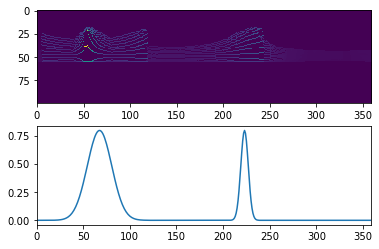

In [32]:
dataset.show(i)
i+=25


In [5]:
def read_and_clean_dataset(PATH_TO_DATAFRAME, max_range = 15):
    complete_dataframe = pd.read_csv(PATH_TO_DATAFRAME) # read dataset
    complete_dataframe = complete_dataframe.iloc[1:,1:]
    train_dataframe: pd.DataFrame  = complete_dataframe.iloc[:,360:]
    target_dataframe = complete_dataframe.iloc[:,0:360]
    print("TRAIN DATAFRAME")
    train_dataframe.info()
    print("TARGET DATAFRAME")
    target_dataframe.info()
    
    train_tensor  = torch.reshape(torch.tensor(train_dataframe.values.astype(np.float)).to(device),[-1,1,100,360])
    target_tensor = torch.tensor(target_dataframe.values.astype(np.float)) .to(device) / 255

    
    n_train = int(train_tensor.shape[0]*0.9)
    n_test = train_tensor.shape[0] - n_train
    
    complete_dataset = data_utils.TensorDataset(train_tensor, target_tensor)
    train_dataset, test_dataset = data_utils.random_split(complete_dataset, [n_train, n_test])
    return train_dataset, test_dataset

### Load

## Train

### Definitions

In [33]:
def basic_train(network, data_loader, criterion, optimizer, n_epochs):
    loss_history = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        print("",end="\r")
        print("Epoch {} out of {}".format(epoch, n_epochs),end="")
        for i, data in enumerate(data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())
    
    
    plt.plot(loss_history)
    plt.show()
    return loss_history

### Run Training

type: gallery_detector_v2, loss: MSELoss, lr: 0.001
Epoch 127 out of 128

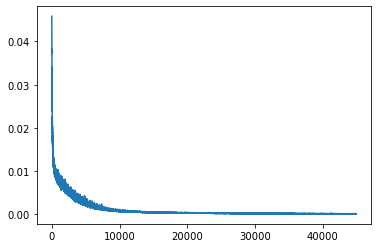

/home/lorenzo/catkin_ws/src/lorenzo/pointcloud_nn/trained_nets_v4/gallery_detector_v2_loss_MSELoss_lr_0.001_N_128__
type: gallery_detector_v2, loss: MSELoss, lr: 0.0005
Epoch 127 out of 128

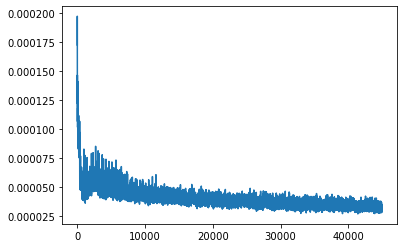

/home/lorenzo/catkin_ws/src/lorenzo/pointcloud_nn/trained_nets_v4/gallery_detector_v2_loss_MSELoss_lr_0.0005_N_128__
type: gallery_detector_v2, loss: MSELoss, lr: 0.0001
Epoch 127 out of 128

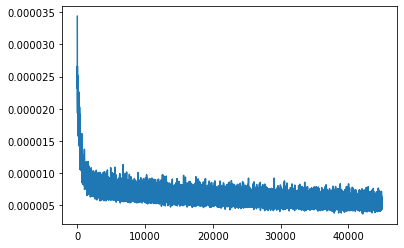

/home/lorenzo/catkin_ws/src/lorenzo/pointcloud_nn/trained_nets_v4/gallery_detector_v2_loss_MSELoss_lr_0.0001_N_128__
type: gallery_detector_v2, loss: MSELoss, lr: 9e-05
Epoch 127 out of 128

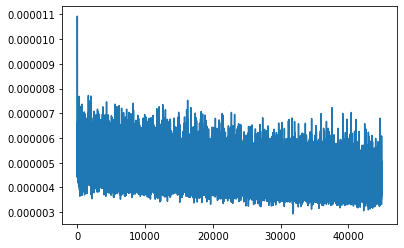

/home/lorenzo/catkin_ws/src/lorenzo/pointcloud_nn/trained_nets_v4/gallery_detector_v2_loss_MSELoss_lr_9e-05_N_128__
type: gallery_detector_v2, loss: MSELoss, lr: 5e-05
Epoch 127 out of 128

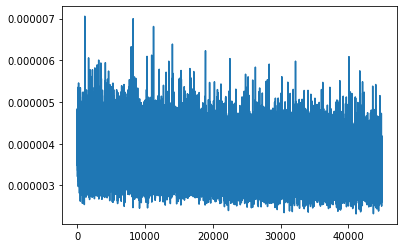

/home/lorenzo/catkin_ws/src/lorenzo/pointcloud_nn/trained_nets_v4/gallery_detector_v2_loss_MSELoss_lr_5e-05_N_128__


In [34]:
torch.cuda.empty_cache()
LR = [0.001, 0.0005, 0.0001, 0.00009, 0.00005]
BATCH_SIZE = 256
N_EPOCHS = 128

train_dataloader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=5)    


criterions = [nn.MSELoss()]
net = NET()
net = net.to(device).float()
for NET in [gallery_detector_v2]:#, gallery_detector_v1]:
    for criterion in criterions:
        for lr in LR:
            torch.cuda.empty_cache()

            print(
                "type: {}, loss: {}, lr: {}".format(
                    NET.__name__, criterion.__class__.__name__, lr
                )
            )
            
            torch.cuda.empty_cache()
            optimizer = optim.Adam(
                net.parameters(),
                lr=lr,
            )
            loss_hist = basic_train(
                net, train_dataloader, criterion, optimizer, N_EPOCHS
            )
            now = datetime.now()
            NN_PATH = "/home/lorenzo/catkin_ws/src/lorenzo/pointcloud_nn/trained_nets_v4/{}_loss_{}_lr_{}_N_{}__".format(
                NET.__name__, criterion.__class__.__name__, lr, N_EPOCHS
            )
            print(NN_PATH)
            torch.save(net.state_dict(), NN_PATH)
